In [2]:
import numpy as np
import keras
from keras.applications.imagenet_utils import decode_predictions

import skimage.io
import skimage.segmentation

import sklearn
import sklearn.metrics
from sklearn.linear_model import LinearRegression

import copy
import warnings

np.random.seed(42)
keras.__version__

'3.11.2'

In [3]:
warnings.filterwarnings('ignore')
model = keras.applications.inception_v3.InceptionV3()

96112376/96112376 ━━━━━━━━━━━━━━━━━━━━ 27s 0us/step


-0.9979664118227225 1.0


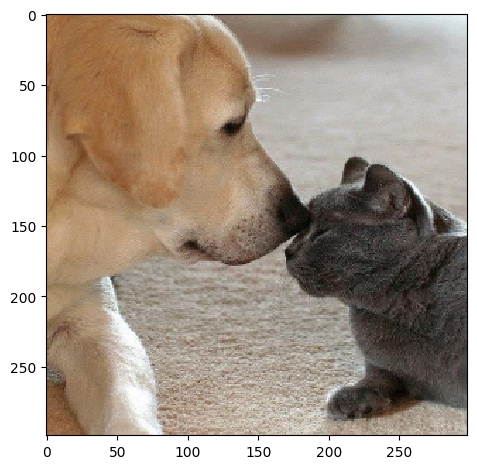

In [6]:
im = skimage.io.imread("cat-and-dog.jpg")
im = skimage.transform.resize(im, (299,299))

im = (im - 0.5)*2  # model's preprocessing, makes it in [-1, 1]
print(im.min(), im.max())

skimage.io.imshow(im/2 + 0.5)  # [-1, 1] -> [-0.5, 0.5] -> [0, 1]

In [7]:
preds = model.predict(im[None,...])
decode_predictions(preds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 2us/step


[[('n02099712', 'Labrador_retriever', np.float32(0.8182908)),
  ('n02099601', 'golden_retriever', np.float32(0.015929852)),
  ('n02093428', 'American_Staffordshire_terrier', np.float32(0.010066439)),
  ('n02108422', 'bull_mastiff', np.float32(0.009287026)),
  ('n02109047', 'Great_Dane', np.float32(0.0086010005))]]

In [14]:
# argsort() gives array of indexes, sorted based on values (logits)
top5 = preds[0].argsort()[-5:][::-1]
top5

array([208, 207, 180, 243, 246])